# Final Post-Clustering Analysis

This notebook performs a comprehensive analysis of post-clustering results with correct responder definition:
- **Responders**: Participants with recall > 2/3 (0.667)
- **Analysis Focus**: Post-clustering metrics only
- **Metrics**: Recall, FAR (False Alarm Rate), Challenge Score (Sensitivity% - 0.4 * FAR/hour)

## Data Source
Uses the feather file with all clustering results for threshold and strategy analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Configure matplotlib
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load the feather data
feather_path = Path('results/final/no-window/train/batch_results/evaluation_results.feather') # Path('results/final/window/test/batch_results_fixed_strategy/evaluation_results.feather')

if not feather_path.exists():
    print(f"Error: Feather file not found at {feather_path}")
    print("Available files in results directory:")
    if Path('results').exists():
        for root, dirs, files in Path('results').walk():
            for file in files:
                if file.endswith('.feather'):
                    print(f"  {root}/{file}")
    else:
        print("  results directory not found")
else:
    # Load the data
    df = pd.read_feather(feather_path)
    print(f"Data loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")


Data loaded successfully!
Shape: (1920, 27)
Columns: ['dataset_id', 'threshold_scale', 'n_samples', 'n_true_anomalies', 'anomaly_percentage', 'has_seizures', 'is_responder_pre', 'is_responder', 'tp_events', 'fn_events', 'fp_events', 'event_recall', 'event_sensitivity', 'event_iou', 'false_alarm_rate_per_hour', 'predicted_samples', 'predicted_percentage', 'processing_timestamp', 'clustering_strategy', 'n_clusters', 'n_representatives', 'cluster_event_recall', 'cluster_event_iou', 'clustered_samples', 'clustered_percentage', 'cluster_event_far_per_hour', 'is_responder_post']


In [3]:
df.columns

Index(['dataset_id', 'threshold_scale', 'n_samples', 'n_true_anomalies',
       'anomaly_percentage', 'has_seizures', 'is_responder_pre',
       'is_responder', 'tp_events', 'fn_events', 'fp_events', 'event_recall',
       'event_sensitivity', 'event_iou', 'false_alarm_rate_per_hour',
       'predicted_samples', 'predicted_percentage', 'processing_timestamp',
       'clustering_strategy', 'n_clusters', 'n_representatives',
       'cluster_event_recall', 'cluster_event_iou', 'clustered_samples',
       'clustered_percentage', 'cluster_event_far_per_hour',
       'is_responder_post'],
      dtype='object')

In [4]:
df.head()

,dataset_id,threshold_scale,n_samples,n_true_anomalies,anomaly_percentage,has_seizures,is_responder_pre,is_responder,tp_events,fn_events,fp_events,event_recall,event_sensitivity,event_iou,false_alarm_rate_per_hour,predicted_samples,predicted_percentage,processing_timestamp,clustering_strategy,n_clusters,n_representatives,cluster_event_recall,cluster_event_iou,clustered_samples,clustered_percentage,cluster_event_far_per_hour,is_responder_post
0,1,0.30,3069312,2568,0.083667,True,True,True,4,0,0,1.0,1.0,0.0,0.000000,3068928,99.987489,2025-09-09T22:30:35.387932,time_2s,1.0,1.0,1.0,1.000000,3068928.0,99.987489,0.000000,True
1,1,0.35,3069312,2568,0.083667,True,True,True,4,0,1,1.0,1.0,0.0,0.009383,3068778,99.982602,2025-09-09T22:30:36.734818,time_2s,2.0,2.0,1.0,0.800000,3068778.0,99.982602,0.009383,True
2,1,0.40,3069312,2568,0.083667,True,True,True,4,0,0,1.0,1.0,0.0,0.000000,3068544,99.974978,2025-09-09T22:30:37.989348,time_2s,1.0,1.0,1.0,1.000000,3068544.0,99.974978,0.000000,True
3,1,0.45,3069312,2568,0.083667,True,True,True,4,0,1,1.0,1.0,0.0,0.009383,3068480,99.972893,2025-09-09T22:30:39.307778,time_2s,2.0,2.0,1.0,0.800000,3068480.0,99.972893,0.009383,True
4,1,0.50,3069312,2568,0.083667,True,True,True,4,0,3,1.0,1.0,0.0,0.028150,3068158,99.962402,2025-09-09T22:30:40.604724,time_2s,4.0,4.0,1.0,0.571429,3068158.0,99.962402,0.028150,True


In [ ]:
# Group thresholds by their mean percentage metrics
threshold_percentages = (
    df.groupby('threshold_scale')
    .agg({
        'anomaly_percentage': 'mean',
        'predicted_percentage': 'mean', 
        'clustered_percentage': 'mean'
    })
    .round(3)
    .reset_index()
)


# Filter out thresholds where predicted percentage > 51%
valid_thresholds_pct = threshold_percentages[threshold_percentages['predicted_percentage'] <= 51]['threshold_scale']

# Filter the main dataframe
df_filtered = df[df['threshold_scale'].isin(valid_thresholds_pct)].copy()

# Show the filtered threshold percentages
threshold_percentages_filtered = threshold_percentages[threshold_percentages['predicted_percentage'] <= 51]
print("\nFiltered mean percentages by threshold:")
threshold_percentages_filtered

Mean percentages by threshold (before filtering):
    threshold_scale  anomaly_percentage  predicted_percentage  \
0              0.30               0.377                99.961   
1              0.35               0.377                99.950   
2              0.40               0.377                99.926   
3              0.45               0.377                99.919   
4              0.50               0.377                99.711   
5              0.55               0.377                99.371   
6              0.60               0.377                93.808   
7              0.65               0.377                67.062   
8              0.70               0.377                25.393   
9              0.75               0.377                 3.465   
10             0.80               0.377                 0.134   
11             0.85               0.377                 0.005   
12             0.90               0.377                 0.001   
13             0.95               0.377 

,threshold_scale,anomaly_percentage,predicted_percentage,clustered_percentage
8,0.70,0.377,25.393,50.680
9,0.75,0.377,3.465,9.082
10,0.80,0.377,0.134,0.334
11,0.85,0.377,0.005,0.024
12,0.90,0.377,0.001,0.027
13,0.95,0.377,0.000,NaN
14,1.00,0.377,0.000,NaN
15,1.05,0.377,0.000,NaN
16,1.10,0.377,0.000,NaN
17,1.15,0.377,0.000,NaN


In [7]:
unique_ids = df['dataset_id'].unique()
unique_ids

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96])

In [8]:
small_df = df_filtered[['threshold_scale', 'event_recall',
       'false_alarm_rate_per_hour',  'clustering_strategy', 'cluster_event_recall', 'cluster_event_far_per_hour',]].copy()
small_df.head(10)

,threshold_scale,event_recall,false_alarm_rate_per_hour,clustering_strategy,cluster_event_recall,cluster_event_far_per_hour
8,0.70,1.00,70.599274,time_60s,1.00,17.180658
9,0.75,0.75,8.688853,time_120s,0.75,5.611160
10,0.80,0.00,0.215814,time_30s,0.00,0.206431
11,0.85,0.00,0.000000,None,NaN,NaN
12,0.90,0.00,0.000000,None,NaN,NaN
13,0.95,0.00,0.000000,None,NaN,NaN
14,1.00,0.00,0.000000,None,NaN,NaN
15,1.05,0.00,0.000000,None,NaN,NaN
16,1.10,0.00,0.000000,None,NaN,NaN
17,1.15,0.00,0.000000,None,NaN,NaN


In [ ]:
# Total number of unique subjects in the dataset
n_subjects = len(unique_ids)

# Count per threshold + strategy
counts = (
    small_df
    .groupby(['threshold_scale', 'clustering_strategy'])
    .size()
    .reset_index(name='count')
)

# Compute total rows per threshold
totals = counts.groupby('threshold_scale')['count'].sum().reset_index(name='total_count')

# # Identify valid thresholds (those with complete subject count)
# valid_thresholds = totals.loc[totals['total_count'] == n_subjects, 'threshold_scale']

# Filter both counts and small_df
counts = counts.merge(totals, on='threshold_scale')
counts = counts[counts['threshold_scale'].copy()

# Add percentages
counts['percentage'] = (
    counts.groupby('threshold_scale')['count']
          .transform(lambda x: 100 * x / x.sum())
)

# Drop helper column
counts = counts.drop(columns='total_count')

# Filter small_df as well
small_df = small_df[small_df['threshold_scale'].isin(valid_thresholds)].copy()
counts

Using all 2 thresholds without subject completeness filtering
Total subjects in dataset: 96
Threshold subject counts:
  Threshold 0.7: 96.0 subjects
  Threshold 0.75: 96.0 subjects


,threshold_scale,clustering_strategy,count,percentage
0,0.70,time_45s,69,71.875000
1,0.70,time_60s,27,28.125000
2,0.75,time_120s,8,8.333333
3,0.75,time_60s,2,2.083333
4,0.75,time_90s,86,89.583333


In [23]:
totals

,threshold_scale,total_count
0,0.70,96
1,0.75,96
2,0.80,95
3,0.85,28
4,0.90,3


In [10]:
# Find the most used strategy per threshold
most_used_strategy = (
    counts
    .loc[counts.groupby('threshold_scale')['count'].idxmax()]
    .reset_index(drop=True)
    [['threshold_scale', 'clustering_strategy', 'count', 'percentage']]
    .sort_values('threshold_scale')
)

print("Most used strategy per threshold:")
most_used_strategy

Most used strategy per threshold:


,threshold_scale,clustering_strategy,count,percentage
0,0.70,time_45s,69,71.875000
1,0.75,time_90s,86,89.583333


In [11]:
import json

# Convert the most_used_strategy DataFrame to the required JSON format
strategies_dict = {
    "strategies": {}
}

for _, row in most_used_strategy.iterrows():
    # Convert threshold to string (as required by the JSON format)
    threshold_str = str(row['threshold_scale'])
    strategy_name = row['clustering_strategy']
    strategies_dict["strategies"][threshold_str] = strategy_name

# Save to JSON file
json_path = 'results/final/no-window/train/batch_results/fixed_strategy_config.json'
with open(json_path, 'w') as f:
    json.dump(strategies_dict, f, indent=2)

print(f"Fixed strategy configuration saved to: {json_path}")
print("Contents:")
print(json.dumps(strategies_dict, indent=2))

Fixed strategy configuration saved to: results/final/no-window/train/batch_results/fixed_strategy_config.json
Contents:
{
  "strategies": {
    "0.7": "time_45s",
    "0.75": "time_90s"
  }
}


In [12]:
import pandas as pd

# Add score (copy to avoid SettingWithCopy warnings if desired)
small_df = small_df.copy()
small_df['score'] = small_df['cluster_event_recall'] * 100 - 0.4 * small_df['cluster_event_far_per_hour']

# 1) Per-threshold x responder-flag
by_flag = (
    small_df
    .groupby(['threshold_scale', 'is_responder_post'])
    .agg(
        mean_recall=('cluster_event_recall', 'mean'),
        mean_far=('cluster_event_far_per_hour', 'mean'),
        mean_score=('score', 'mean'),
        count=('is_responder_post', 'size')
    )
    .reset_index()
)
by_flag['mean_recall'] = by_flag['mean_recall'] * 100
by_flag['is_responder_post'] = by_flag['is_responder_post'].map({True: 'responders', False: 'non_responders'})

# 2) True overall per-threshold (“all” = responders + non_responders)
overall = (
    small_df
    .groupby('threshold_scale')
    .agg(
        mean_recall=('cluster_event_recall', 'mean'),
        mean_far=('cluster_event_far_per_hour', 'mean'),
        mean_score=('score', 'mean'),
        count=('is_responder_post', 'size')
    )
    .reset_index()
)
overall['mean_recall'] = overall['mean_recall'] * 100
overall['is_responder_post'] = 'all'

# 3) Combine and pivot
summary = pd.concat([by_flag, overall], ignore_index=True)

table = summary.pivot(
    index='threshold_scale',
    columns='is_responder_post',
    values=['mean_recall', 'mean_far', 'mean_score', 'count']
)

# Flatten columns
table.columns = [f"{metric}_{group}" for metric, group in table.columns]
table = table.reset_index()

# 4) Responder ratio = responders / all
table['responder_ratio'] = table['count_responders'] / table['count_all']

# (Optional) drop raw counts if you don’t need them
table = table.drop(columns=[c for c in table.columns if c.startswith('count_')])

table

KeyError: 'is_responder_post'

/tmp/ipykernel_4073027/1329105620.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.title("Mean Score by Threshold"); plt.legend(); plt.grid(True)


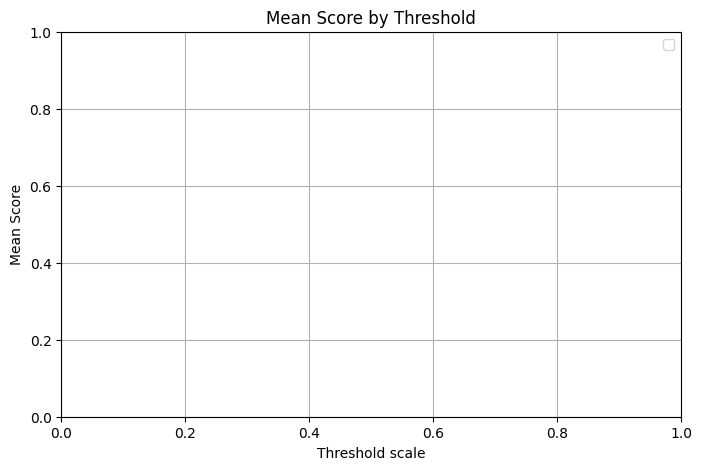

NameError: name 'table' is not defined

<Figure size 800x500 with 0 Axes>

In [18]:
# ---- Visualizations ----
plt.figure(figsize=(8,5))
#plt.plot(table['threshold_scale'], table['mean_score_all'], marker='o', label='All')
#plt.plot(table['threshold_scale'], table['mean_score_responders'], marker='o', label='Responders')
plt.xlabel("Threshold scale"); plt.ylabel("Mean Score")
plt.title("Mean Score by Threshold"); plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(table['threshold_scale'], table['mean_recall_all'], marker='o', label='All')
plt.plot(table['threshold_scale'], table['mean_recall_responders'], marker='o', label='Responders')
plt.xlabel("Threshold scale"); plt.ylabel("Mean Recall (%)")
plt.title("Mean Recall by Threshold"); plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(table['threshold_scale'], table['mean_far_all'], marker='o', label='All')
plt.plot(table['threshold_scale'], table['mean_far_responders'], marker='o', label='Responders')
plt.xlabel("Threshold scale"); plt.ylabel("Mean FAR (per hour)")
plt.title("Mean FAR by Threshold"); plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.bar(table['threshold_scale'], table['responder_ratio'])
plt.xlabel("Threshold scale"); plt.ylabel("Responder Ratio")
plt.title("Responder Ratio by Threshold")
plt.show()

# ---- Analysis of best thresholds ----
analysis = {
    "best_score_all": table.loc[table['mean_score_all'].idxmax(), 'threshold_scale'],
    "best_score_responders": table.loc[table['mean_score_responders'].idxmax(), 'threshold_scale'],
    "highest_recall_all": table.loc[table['mean_recall_all'].idxmax(), 'threshold_scale'],
    "highest_recall_responders": table.loc[table['mean_recall_responders'].idxmax(), 'threshold_scale'],
    "lowest_far_all": table.loc[table['mean_far_all'].idxmin(), 'threshold_scale'],
    "lowest_far_responders": table.loc[table['mean_far_responders'].idxmin(), 'threshold_scale'],
    "highest_responder_ratio": table.loc[table['responder_ratio'].idxmax(), 'threshold_scale'],
}

analysis_df = pd.DataFrame(list(analysis.items()), columns=["criterion", "best_threshold"])
print(analysis_df)

In [14]:
def threshold_metrics(df, threshold):
    """
    Compute mean Recall, FAR, Score for responders and all,
    plus responder ratio, for a given threshold.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain: threshold_scale, cluster_event_recall, 
        cluster_event_far_per_hour, is_responder_post
    threshold : value
        The threshold_scale to filter on

    Returns
    -------
    dict
        Dictionary with metrics for responders, all, and responder ratio
    """
    # Filter for threshold
    sub = df[df['threshold_scale'] == threshold].copy()
    if sub.empty:
        raise ValueError(f"No data for threshold {threshold}")

    # Compute score per row
    sub['score'] = sub['cluster_event_recall'] * 100 - 0.4 * sub['cluster_event_far_per_hour']

    # --- Responders only ---
    resp = sub[sub['is_responder_post'] == True]
    resp_recall = resp['cluster_event_recall'].mean() * 100 if not resp.empty else float('nan')
    resp_far = resp['cluster_event_far_per_hour'].mean() if not resp.empty else float('nan')
    resp_score = resp['score'].mean() if not resp.empty else float('nan')

    # --- All (responders + non-responders) ---
    all_recall = sub['cluster_event_recall'].mean() * 100
    all_far = sub['cluster_event_far_per_hour'].mean()
    all_score = sub['score'].mean()

    # --- Responder ratio ---
    responder_ratio = sub['is_responder_post'].mean()

    return {
        "responders": {
            "mean_recall": resp_recall,
            "mean_far": resp_far,
            "mean_score": resp_score,
        },
        "all": {
            "mean_recall": all_recall,
            "mean_far": all_far,
            "mean_score": all_score,
        },
        "responder_ratio": responder_ratio
    }

In [15]:
# metrics = threshold_metrics(small_df, threshold=0.2)
# metrics

In [16]:
rows = []
for _, row in analysis_df.iterrows():
    crit = row['criterion']
    thr = row['best_threshold']
    m = threshold_metrics(small_df, thr)
    rows.append({
        "criterion": crit,
        "threshold_scale": thr,
        "mean_recall_responders": m["responders"]["mean_recall"],
        "mean_far_responders": m["responders"]["mean_far"],
        "mean_score_responders": m["responders"]["mean_score"],
        "mean_recall_all": m["all"]["mean_recall"],
        "mean_far_all": m["all"]["mean_far"],
        "mean_score_all": m["all"]["mean_score"],
        "responder_ratio": m["responder_ratio"]
    })

metrics_table = pd.DataFrame(rows).round(3)

display(metrics_table)

NameError: name 'analysis_df' is not defined

In [ ]:
metrics_table.to_feather('results/final/no-window/train/batch_results_fixed_strategy/summary_metrics_table.feather') 

In [ ]:
unique_thresholds = metrics_table['threshold_scale'].unique()
unique_thresholds.sort()
unique_thresholds

array([0.65, 0.7 , 0.75])

In [19]:
import pandas as pd

# Build the grouped (MultiIndex) table from your existing flat metrics_table
def to_grouped_table(analysis_df, small_df):
    def threshold_metrics(df, threshold):
        sub = df[df['threshold_scale'] == threshold].copy()
        if sub.empty:
            raise ValueError(f"No data for threshold {threshold}")
        sub['score'] = sub['cluster_event_recall'] * 100 - 0.4 * sub['cluster_event_far_per_hour']

        # responders
        resp = sub[sub['is_responder_post'] == True]
        resp_recall = resp['cluster_event_recall'].mean() * 100 if not resp.empty else float('nan')
        resp_far = resp['cluster_event_far_per_hour'].mean() if not resp.empty else float('nan')
        resp_score = resp['score'].mean() if not resp.empty else float('nan')

        # all (responders + non-responders)
        all_recall = sub['cluster_event_recall'].mean() * 100
        all_far = sub['cluster_event_far_per_hour'].mean()
        all_score = sub['score'].mean()

        # responder ratio
        responder_ratio = sub['is_responder_post'].mean()

        return {
            "responders": {"mean_recall": resp_recall, "mean_far": resp_far, "mean_score": resp_score},
            "all": {"mean_recall": all_recall, "mean_far": all_far, "mean_score": all_score},
            "responder_ratio": responder_ratio
        }

    rows = []
    for _, r in analysis_df.iterrows():
        crit = r['criterion']
        thr  = r['best_threshold']
        m = threshold_metrics(small_df, thr)
        rows.append([
            crit, thr,
            m["responders"]["mean_recall"], m["responders"]["mean_far"], m["responders"]["mean_score"],
            m["all"]["mean_recall"],        m["all"]["mean_far"],        m["all"]["mean_score"],
            m["responder_ratio"]
        ])

    df = pd.DataFrame(rows, columns=[
        ("", "criterion"),
        ("", "threshold_scale"),
        ("Responders", "mean_recall"),
        ("Responders", "mean_far"),
        ("Responders", "mean_score"),
        ("All", "mean_recall"),
        ("All", "mean_far"),
        ("All", "mean_score"),
        ("", "responder_ratio"),
    ])
    df.columns = pd.MultiIndex.from_tuples(df.columns)

    # Proper rounding using IndexSlice (specify BOTH top-level headers)
    idx = pd.IndexSlice
    metric_cols = (['Responders', 'All'], ['mean_recall', 'mean_far', 'mean_score'])
    df.loc[:, idx[metric_cols[0], metric_cols[1]]] = (
        df.loc[:, idx[metric_cols[0], metric_cols[1]]].round(3)
    )
    df.loc[:, idx['', 'responder_ratio']] = df.loc[:, idx['', 'responder_ratio']].round(3)

    return df

grouped_metrics_table = to_grouped_table(analysis_df, small_df)
grouped_metrics_table

NameError: name 'analysis_df' is not defined

In [20]:
(grouped_metrics_table
 .style
 .format(precision=3, na_rep="–")
 .set_caption("Best Thresholds per Criterion — Responders vs All")
)

NameError: name 'grouped_metrics_table' is not defined

In [21]:
# Pick colors for the column groups
header_colors = {
    "Responders": "background-color: #d1e7dd;",  # light green
    "All": "background-color: #cfe2ff;",         # light blue
}

def color_top_level(val):
    if val in header_colors:
        return header_colors[val]
    return ""

styled = (
    grouped_metrics_table
    .style
    .format(precision=3, na_rep="–")
    .set_caption("Best Thresholds per Criterion — Responders vs All")
    .set_table_styles(
        # Apply colors to top-level headers
        [{ "selector": f"th.col{i}.level0", "props": header_colors.get(lbl, "") }
         for i, lbl in enumerate(grouped_metrics_table.columns.get_level_values(0))]
    )
)
styled

NameError: name 'grouped_metrics_table' is not defined